In [1]:
# Core Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.transform import resize # Using scikit-image for resizing

# Keras / TensorFlow Components
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import (Input, GlobalAveragePooling2D, Dense, Dropout, GlobalMaxPooling1D, Lambda ,concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence

# Scikit-learn for evaluation
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, roc_curve

print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow Version: 2.19.0
Num GPUs Available:  0


In [2]:
# TODO: Set these paths according to your MRNet dataset location
BASE_DATA_DIR = './dataset/' # Base directory of the extracted MRNet dataset
OUTPUT_DIR = './output_models/' # Where to save trained models and logs

# Select the plane to train on
# Options: 'axial', 'coronal', 'sagittal'
PLANE = 'sagittal'

# Model & Training Hyperparameters
IMG_SIZE = (299, 299) # Input size for Xception
N_CHANNELS = 3 # Xception expects 3 channels (we'll stack grayscale)
BATCH_SIZE = 4 # <<< Adjust based on GPU memory (can be small like 2 or 4)
EPOCHS = 25 # Max number of training epochs (EarlyStopping will likely stop it sooner)
LEARNING_RATE = 1e-4 # Initial learning rate for Adam optimizer
DROPOUT_RATE = 0.5 # Dropout rate for the classification head

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Construct model save path based on the chosen plane
MODEL_SAVE_PATH = os.path.join(OUTPUT_DIR, f'xception_mrnet_{PLANE}_best.h5')
print(f"Selected Plane: {PLANE}")
print(f"Model will be saved to: {MODEL_SAVE_PATH}")

Selected Plane: sagittal
Model will be saved to: ./output_models/xception_mrnet_sagittal_best.h5


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"Successfully configured memory growth for {len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(f"Error setting memory growth: {e}")
else:
    print("No GPUs detected. Running on CPU (will be very slow).")

No GPUs detected. Running on CPU (will be very slow).


In [4]:
def load_labels(label_dir, task, split):
    """Loads labels for a specific task (acl, meniscus) and split (train, valid)."""
    label_path = os.path.join(label_dir, f"{split}-{task}.csv")
    try:
        labels_df = pd.read_csv(label_path, header=None, names=['exam_id', 'label'], dtype={'exam_id': str})
        # Filter out rows with non-integer labels
        labels_df = labels_df[pd.to_numeric(labels_df['label'], errors='coerce').notnull()]
        labels_df['label'] = labels_df['label'].astype(int)  # Convert to integer
        labels_df.set_index('exam_id', inplace=True)
        print(f"Loaded {len(labels_df)} labels for {task} - {split} split.")
        return labels_df['label'].to_dict()
    except FileNotFoundError:
        print(f"Error: Label file not found at {label_path}")
        return {}

def preprocess_slice(slice_img, target_size=(299, 299)):
    """Preprocesses a single 2D slice: resizes, normalizes, and stacks to 3 channels."""
    # Ensure input is float for calculations
    slice_img = slice_img.astype(np.float32)

    # 1. Resize
    # Note: anti_aliasing=True is generally recommended but can be slower.
    # You might need `pip install scikit-image`
    slice_resized = resize(slice_img, target_size, anti_aliasing=True, preserve_range=True) # preserve_range=True is important before custom norm

    # 2. Normalize (Example: Scale to [0, 1] based on slice intensity)
    # The MRNet paper used scan-specific Z-score normalization, which might be better.
    # This simple scaling is easier to implement initially.
    min_val = np.min(slice_resized)
    max_val = np.max(slice_resized)
    if max_val > min_val:
        slice_normalized = (slice_resized - min_val) / (max_val - min_val)
    else:
        slice_normalized = np.zeros(target_size) # Handle blank slices

    # 3. Stack to 3 Channels for Xception input
    slice_3channel = np.stack([slice_normalized] * 3, axis=-1)

    return slice_3channel.astype(np.float32)

In [5]:
class MRNetSequence(Sequence):
    """ Keras Sequence for loading MRNet data slice by slice. """
    def __init__(self, data_dir, plane, labels_acl, labels_meniscus, exam_ids, batch_size, target_size, is_train=True):
        self.data_dir = data_dir
        self.plane = plane
        self.labels_acl = labels_acl
        self.labels_meniscus = labels_meniscus
        # Ensure exam_ids are strings to match dictionary keys
        self.exam_ids = [str(eid) for eid in exam_ids]
        self.batch_size = batch_size # Note: this is exam batch size
        self.target_size = target_size
        self.is_train = is_train # Flag to enable shuffling for training data
        self.indices = np.arange(len(self.exam_ids))
        if self.is_train:
            self.shuffle() # Initial shuffle for training

    def __len__(self):
        # Number of batches per epoch (based on exams)
        return int(np.ceil(len(self.exam_ids) / self.batch_size))

    def __getitem__(self, index):
        # Get batch indices for exams
        batch_exam_indices = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        batch_exam_ids = [self.exam_ids[i] for i in batch_exam_indices]

        batch_slices_list = []
        batch_labels_acl_list = []
        batch_labels_meniscus_list = []

        for exam_id in batch_exam_ids:
            exam_path = os.path.join(self.data_dir, self.plane, f"{exam_id}.npy")
            try:
                # Load the 3D volume for the exam
                volume = np.load(exam_path) # Shape: (num_slices, height, width)
            except FileNotFoundError:
                print(f"\nWarning: File not found {exam_path}. Skipping exam {exam_id}.")
                continue
            except ValueError as e:
                 print(f"\nWarning: Error loading {exam_path}: {e}. Skipping exam {exam_id}.")
                 continue


            # Get exam labels (using .get for safety, although IDs should exist)
            label_acl = self.labels_acl.get(exam_id)
            label_meniscus = self.labels_meniscus.get(exam_id)

            if label_acl is None or label_meniscus is None:
                print(f"\nWarning: Labels not found for exam {exam_id}. Skipping.")
                continue

            # Preprocess each slice and collect
            num_slices_in_volume = volume.shape[0]
            for i in range(num_slices_in_volume):
                slice_img = volume[i]
                processed_slice = preprocess_slice(slice_img, self.target_size)
                batch_slices_list.append(processed_slice)
                batch_labels_acl_list.append(label_acl)
                batch_labels_meniscus_list.append(label_meniscus)

        # Convert lists to numpy arrays for the batch
        batch_slices_np = np.array(batch_slices_list)
        batch_labels_acl_np = np.array(batch_labels_acl_list, dtype=np.float32)
        batch_labels_meniscus_np = np.array(batch_labels_meniscus_list, dtype=np.float32)

        # Return batch data in the format Keras expects
        # x: batch of slices, y: dictionary matching model output names
        return batch_slices_np, {'acl_output': batch_labels_acl_np, 'meniscus_output': batch_labels_meniscus_np}

    def shuffle(self):
         """Shuffles the order of exams"""
         np.random.shuffle(self.indices)

    def on_epoch_end(self):
        # Shuffle exam indices after each epoch if this is for training
        if self.is_train:
            self.shuffle()
            # print("\nShuffled training exam indices for next epoch.")

In [6]:
def build_xception_model(input_shape, num_classes_acl=1, num_classes_meniscus=1, dropout_rate=0.5):
    """Builds the Xception model for slice-level prediction with two output heads."""
    # --- Base Model (Xception) ---
    # include_top=False: Remove the original ImageNet classification layer
    # pooling=None: We'll add our own pooling after the base model
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape, pooling=None)

    # --- Freeze Base Model Layers ---
    # Start by freezing the pre-trained weights. We'll only train the new layers initially.
    base_model.trainable = False

    # --- Input Layer ---
    # Define the input tensor matching the preprocessed slice shape
    slice_input = Input(shape=input_shape, name="slice_input")

    # --- Connect Input to Base Model ---
    # Pass the input through the base model.
    # training=False is crucial here when base_model is frozen, to ensure BatchNorm layers run in inference mode.
    x = base_model(slice_input, training=False)

    # --- Pooling Layer (Per Slice) ---
    # Apply Global Average Pooling to the output features of the base model for each slice.
    # This reduces spatial dimensions to a single feature vector per slice.
    x = GlobalAveragePooling2D(name="slice_gap")(x)

    # --- Classification Head ---
    # Add Dropout for regularization before the final Dense layers
    x = Dropout(dropout_rate, name="head_dropout")(x)

    # Output layer for ACL Tear classification (Sigmoid for binary probability)
    acl_output = Dense(num_classes_acl, activation='sigmoid', name='acl_output')(x)

    # Output layer for Meniscus Tear classification (Sigmoid for binary probability)
    # This head branches off from the same pooled & dropout features.
    meniscus_output = Dense(num_classes_meniscus, activation='sigmoid', name='meniscus_output')(x)

    # --- Create and Return Model ---
    # Define the model with one input (slice_input) and two outputs (acl_output, meniscus_output)
    model = Model(inputs=slice_input, outputs=[acl_output, meniscus_output], name=f"Xception_MRNet_{PLANE}")

    return model

In [7]:
def evaluate_model_aggregated(model, data_dir, plane, labels_acl, labels_meniscus, exam_ids, target_size):
    """Evaluates the slice-level model using exam-level aggregation (Max Pooling)."""
    true_labels_acl = []
    true_labels_meniscus = []
    pred_probs_acl = []
    pred_probs_meniscus = []

    print(f"\nStarting exam-level evaluation on {len(exam_ids)} exams using plane '{plane}'...")
    progbar = tf.keras.utils.Progbar(len(exam_ids))

    # Ensure exam_ids are strings
    exam_ids = [str(eid) for eid in exam_ids]

    for i, exam_id in enumerate(exam_ids):
        exam_path = os.path.join(data_dir, plane, f"{exam_id}.npy")
        try:
            volume = np.load(exam_path)
        except FileNotFoundError:
            print(f"Warning: Eval File not found {exam_path}. Skipping exam {exam_id}.")
            progbar.update(i + 1) # Update progress bar even if skipped
            continue
        except ValueError as e:
            print(f"Warning: Error loading eval file {exam_path}: {e}. Skipping exam {exam_id}.")
            progbar.update(i + 1)
            continue


        # Get true labels for the exam
        label_acl = labels_acl.get(exam_id)
        label_meniscus = labels_meniscus.get(exam_id)

        if label_acl is None or label_meniscus is None:
            print(f"Warning: Eval Labels not found for exam {exam_id}. Skipping.")
            progbar.update(i + 1)
            continue

        # Process all slices in the volume
        exam_slices_processed = []
        num_slices_in_volume = volume.shape[0]
        if num_slices_in_volume == 0:
             print(f"Warning: Exam {exam_id} has 0 slices. Skipping.")
             progbar.update(i + 1)
             continue

        for slice_idx in range(num_slices_in_volume):
            processed_slice = preprocess_slice(volume[slice_idx], target_size)
            exam_slices_processed.append(processed_slice)

        # Stack slices into a batch for prediction
        exam_slices_np = np.array(exam_slices_processed)

        # Get slice-level predictions from the model
        # model.predict yields a list [preds_acl, preds_meniscus]
        # each element has shape (num_slices, 1)
        slice_preds = model.predict(exam_slices_np, batch_size=len(exam_slices_np), verbose=0)
        slice_preds_acl = slice_preds[0].flatten() # Shape: (num_slices,)
        slice_preds_meniscus = slice_preds[1].flatten() # Shape: (num_slices,)

        # --- Aggregation Step (Max Pooling) ---
        # Take the maximum probability across all slices for this exam
        exam_pred_prob_acl = np.max(slice_preds_acl) if len(slice_preds_acl) > 0 else 0.5 # Default to 0.5 if no slices
        exam_pred_prob_meniscus = np.max(slice_preds_meniscus) if len(slice_preds_meniscus) > 0 else 0.5

        # Store results
        true_labels_acl.append(label_acl)
        true_labels_meniscus.append(label_meniscus)
        pred_probs_acl.append(exam_pred_prob_acl)
        pred_probs_meniscus.append(exam_pred_prob_meniscus)

        progbar.update(i + 1) # Update progress bar

    # --- Calculate Metrics ---
    print("\n--- Aggregated Evaluation Results ---")
    if not true_labels_acl: # Check if any exams were successfully processed
         print("No valid exams found or processed for evaluation.")
         return None, None # Return None for AUCs if no data

    # Convert lists to numpy arrays for sklearn metrics
    true_labels_acl = np.array(true_labels_acl)
    true_labels_meniscus = np.array(true_labels_meniscus)
    pred_probs_acl = np.array(pred_probs_acl)
    pred_probs_meniscus = np.array(pred_probs_meniscus)

    # Calculate predicted labels based on 0.5 threshold for Accuracy
    pred_labels_acl = (pred_probs_acl > 0.5).astype(int)
    pred_labels_meniscus = (pred_probs_meniscus > 0.5).astype(int)

    # Calculate AUC, Accuracy, Log Loss for each task
    auc_acl = roc_auc_score(true_labels_acl, pred_probs_acl)
    acc_acl = accuracy_score(true_labels_acl, pred_labels_acl)
    loss_acl = log_loss(true_labels_acl, pred_probs_acl)

    auc_meniscus = roc_auc_score(true_labels_meniscus, pred_probs_meniscus)
    acc_meniscus = accuracy_score(true_labels_meniscus, pred_labels_meniscus)
    loss_meniscus = log_loss(true_labels_meniscus, pred_probs_meniscus)

    # Calculate the average AUC (primary MRNet metric)
    avg_auc = (auc_acl + auc_meniscus) / 2.0

    print(f"Results for Plane: {plane}")
    print(f"ACL Task:")
    print(f"  AUC:      {auc_acl:.4f}")
    print(f"  Accuracy: {acc_acl:.4f} (Threshold 0.5)")
    print(f"  Log Loss: {loss_acl:.4f}")
    print(f"Meniscus Task:")
    print(f"  AUC:      {auc_meniscus:.4f}")
    print(f"  Accuracy: {acc_meniscus:.4f} (Threshold 0.5)")
    print(f"  Log Loss: {loss_meniscus:.4f}")
    print(f"-----------------------------")
    print(f"Average Exam AUC: {avg_auc:.4f}")
    print("-----------------------------")

    # Return calculated metrics (optional)
    results = {
        'acl': {'auc': auc_acl, 'acc': acc_acl, 'loss': loss_acl, 'true': true_labels_acl, 'pred_prob': pred_probs_acl},
        'meniscus': {'auc': auc_meniscus, 'acc': acc_meniscus, 'loss': loss_meniscus, 'true': true_labels_meniscus, 'pred_prob': pred_probs_meniscus},
        'avg_auc': avg_auc
    }
    return results

In [8]:
train_data_dir = os.path.join(BASE_DATA_DIR, 'train')
valid_data_dir = os.path.join(BASE_DATA_DIR, 'valid')
label_dir = BASE_DATA_DIR # Assuming label CSVs are in the base directory

# --- Load Labels ---
print("Loading labels...")
train_labels_acl = load_labels(label_dir, 'acl', 'train')
train_labels_meniscus = load_labels(label_dir, 'meniscus', 'train')
valid_labels_acl = load_labels(label_dir, 'acl', 'valid')
valid_labels_meniscus = load_labels(label_dir, 'meniscus', 'valid')

# --- Get Exam IDs ---
# Assumes exam IDs are the filenames without the .npy extension
# Use chosen PLANE to list files
try:
    train_exam_ids = sorted([f.split('.')[0] for f in os.listdir(os.path.join(train_data_dir, PLANE)) if f.endswith('.npy')])
    valid_exam_ids = sorted([f.split('.')[0] for f in os.listdir(os.path.join(valid_data_dir, PLANE)) if f.endswith('.npy')])
    print(f"\nFound {len(train_exam_ids)} training exams for plane {PLANE}.")
    print(f"Found {len(valid_exam_ids)} validation exams for plane {PLANE}.")
    # Simple validation: Check if first few IDs exist in loaded labels
    if train_exam_ids and (train_exam_ids[0] not in train_labels_acl or train_exam_ids[0] not in train_labels_meniscus):
         print(f"Warning: Mismatch detected between file IDs (e.g., {train_exam_ids[0]}) and label IDs. Check load_labels and file names.")
    if valid_exam_ids and (valid_exam_ids[0] not in valid_labels_acl or valid_exam_ids[0] not in valid_labels_meniscus):
         print(f"Warning: Mismatch detected between file IDs (e.g., {valid_exam_ids[0]}) and label IDs.")

except FileNotFoundError:
    print(f"\nError: Could not find data directory for plane '{PLANE}' in {train_data_dir} or {valid_data_dir}.")
    print("Please ensure BASE_DATA_DIR is correct and contains 'train'/'valid' subfolders with '{PLANE}' subfolders.")
    # Stop execution if data isn't found
    raise

# --- Create Data Generators ---
print("\nCreating data generators...")
train_gen = MRNetSequence(train_data_dir, PLANE, train_labels_acl, train_labels_meniscus,
                          train_exam_ids, BATCH_SIZE, IMG_SIZE, is_train=True)

valid_gen = MRNetSequence(valid_data_dir, PLANE, valid_labels_acl, valid_labels_meniscus,
                          valid_exam_ids, BATCH_SIZE, IMG_SIZE, is_train=False) # is_train=False for validation (no shuffling)

Loading labels...
Loaded 1130 labels for acl - train split.
Loaded 1130 labels for meniscus - train split.
Loaded 120 labels for acl - valid split.
Loaded 120 labels for meniscus - valid split.

Found 1130 training exams for plane sagittal.
Found 120 validation exams for plane sagittal.

Creating data generators...


In [ ]:
# --- Build Model ---
print("\nBuilding model...")
model = build_xception_model(input_shape=(*IMG_SIZE, N_CHANNELS),
                             dropout_rate=DROPOUT_RATE)

# --- Compile Model ---
# We have two outputs, so we use a dictionary for losses and metrics.
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss={'acl_output': BinaryCrossentropy(name='acl_loss'),
                    'meniscus_output': BinaryCrossentropy(name='meniscus_loss')},
              loss_weights={'acl_output': 1.0, 'meniscus_output': 1.0}, # Give equal importance to both tasks
              metrics={'acl_output': [AUC(name='auc_acl'), BinaryAccuracy(name='acc_acl')],
                       'meniscus_output': [AUC(name='auc_meniscus'), BinaryAccuracy(name='acc_meniscus')]})

print("\nModel Summary:")
model.summary()

# --- Callbacks ---
print("\nSetting up callbacks...")
# Save the best model based on validation loss (sum of both task losses)
checkpoint = ModelCheckpoint(MODEL_SAVE_PATH,
                             monitor='val_loss', # Monitor the total validation loss
                             save_best_only=True,
                             save_weights_only=False, # Save the entire model structure + weights
                             mode='min', # Minimize the validation loss
                             verbose=1)

# Stop training early if validation loss doesn't improve
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10, # Stop after 10 epochs of no improvement in val_loss
                               mode='min',
                               restore_best_weights=True, # Load weights from the best epoch found
                               verbose=1)

# Reduce learning rate if validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2, # Reduce LR by a factor of 5 (lr = lr * 0.2)
                              patience=5,  # Reduce LR after 5 epochs of no improvement
                              mode='min',
                              min_lr=1e-6, # Minimum learning rate
                              verbose=1)

# --- Train Model ---
print(f"\n--- Starting Training for {PLANE} plane ---")
print(f"Epochs: {EPOCHS}, Batch Size (Exams): {BATCH_SIZE}, Learning Rate: {LEARNING_RATE}")

# Check if generators have data
if len(train_gen) == 0 or len(valid_gen) == 0:
     print("\nError: Training or validation generator is empty. Cannot start training.")
     print(f"Check if data exists in '{train_data_dir}/{PLANE}' and '{valid_data_dir}/{PLANE}'.")
else:
    history = model.fit(train_gen,
                        epochs=EPOCHS,
                        validation_data=valid_gen,
                        callbacks=[checkpoint, early_stopping, reduce_lr],
                        verbose=1) # Set verbose=1 or 2 to see progress per epoch

    print("\n--- Training Finished ---")

    # --- Plot Training History ---
    if 'history' in locals() and history is not None:
        print("\nPlotting training history...")
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Loss Plot
        axes[0].plot(history.history['loss'], label='Train Loss')
        axes[0].plot(history.history['val_loss'], label='Validation Loss')
        axes[0].set_title(f'{PLANE} - Model Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss (BCE)')
        axes[0].legend()
        axes[0].grid(True)

        # AUC Plot (Average of ACL and Meniscus AUC)
        # Note: Keras history keys might vary slightly based on TF version, check history.history.keys() if needed
        train_auc_avg = (np.array(history.history.get('acl_output_auc_acl', history.history.get('auc_acl', 0))) +
                         np.array(history.history.get('meniscus_output_auc_meniscus', history.history.get('auc_meniscus', 0)))) / 2.0
        val_auc_avg = (np.array(history.history.get('val_acl_output_auc_acl', history.history.get('val_auc_acl', 0))) +
                       np.array(history.history.get('val_meniscus_output_auc_meniscus', history.history.get('val_auc_meniscus', 0)))) / 2.0

        axes[1].plot(train_auc_avg, label='Train Avg AUC')
        axes[1].plot(val_auc_avg, label='Validation Avg AUC')
        axes[1].set_title(f'{PLANE} - Model Average AUC')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Average AUC')
        axes[1].legend()
        axes[1].grid(True)

        plt.tight_layout()
        plt.show()
    else:
        print("Skipping history plots as training did not complete successfully.")

# --- Save Model to H5 File ---
print("\nSaving the trained model to H5 file...")
model.save(MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")


Building model...

Model Summary:


Model: "Xception_MRNet_sagittal"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ slice_input         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xception            │ (None, 10, 10,    │ 20,861,480 │ slice_input[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_gap           │ (None, 2048)      │          0 │ xception[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_dropout        │ (None, 2048)      │          0 │ slice_gap[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ acl_output (Dense)  │ (None, 1)         │      2,049 │ head_dropout[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meniscus_output     │ (None, 1)         │      2,049 │ head_dropout[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,865,578 (79.60 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 20,861,480 (79.58 MB)


Setting up callbacks...

--- Starting Training for sagittal plane ---
Epochs: 25, Batch Size (Exams): 4, Learning Rate: 0.0001


c:\Users\Marc Velasquez\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - acl_output_acc_acl: 0.7707 - acl_output_auc_acl: 0.5015 - acl_output_loss: 0.5417 - loss: 1.2259 - meniscus_output_acc_meniscus: 0.5714 - meniscus_output_auc_meniscus: 0.5100 - meniscus_output_loss: 0.6829
Epoch 1: val_loss improved from inf to 1.56463, saving model to ./output_models/xception_mrnet_sagittal_best.h5


283/283 ━━━━━━━━━━━━━━━━━━━━ 2156s 8s/step - acl_output_acc_acl: 0.7708 - acl_output_auc_acl: 0.5015 - acl_output_loss: 0.5416 - loss: 1.2257 - meniscus_output_acc_meniscus: 0.5715 - meniscus_output_auc_meniscus: 0.5100 - meniscus_output_loss: 0.6829 - val_acl_output_acc_acl: 0.5605 - val_acl_output_auc_acl: 0.5556 - val_acl_output_loss: 0.8638 - val_loss: 1.5646 - val_meniscus_output_acc_meniscus: 0.5405 - val_meniscus_output_auc_meniscus: 0.6013 - val_meniscus_output_loss: 0.6955 - learning_rate: 1.0000e-04
Epoch 2/25
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - acl_output_acc_acl: 0.8205 - acl_output_auc_acl: 0.5133 - acl_output_loss: 0.4810 - loss: 1.1342 - meniscus_output_acc_meniscus: 0.6349 - meniscus_output_auc_meniscus: 0.5592 - meniscus_output_loss: 0.6504
Epoch 2: val_loss improved from 1.56463 to 1.52405, saving model to ./output_models/xception_mrnet_sagittal_best.h5


283/283 ━━━━━━━━━━━━━━━━━━━━ 2029s 7s/step - acl_output_acc_acl: 0.8205 - acl_output_auc_acl: 0.5133 - acl_output_loss: 0.4810 - loss: 1.1343 - meniscus_output_acc_meniscus: 0.6348 - meniscus_output_auc_meniscus: 0.5592 - meniscus_output_loss: 0.6504 - val_acl_output_acc_acl: 0.5605 - val_acl_output_auc_acl: 0.5992 - val_acl_output_loss: 0.8573 - val_loss: 1.5240 - val_meniscus_output_acc_meniscus: 0.5583 - val_meniscus_output_auc_meniscus: 0.6357 - val_meniscus_output_loss: 0.6661 - learning_rate: 1.0000e-04
Epoch 3/25
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - acl_output_acc_acl: 0.8110 - acl_output_auc_acl: 0.5269 - acl_output_loss: 0.4917 - loss: 1.1387 - meniscus_output_acc_meniscus: 0.6213 - meniscus_output_auc_meniscus: 0.5926 - meniscus_output_loss: 0.6456
Epoch 3: val_loss did not improve from 1.52405
283/283 ━━━━━━━━━━━━━━━━━━━━ 2024s 7s/step - acl_output_acc_acl: 0.8110 - acl_output_auc_acl: 0.5270 - acl_output_loss: 0.4917 - loss: 1.1387 - meniscus_output_acc_meniscus: 0.621

283/283 ━━━━━━━━━━━━━━━━━━━━ 2023s 7s/step - acl_output_acc_acl: 0.8191 - acl_output_auc_acl: 0.5361 - acl_output_loss: 0.4803 - loss: 1.1125 - meniscus_output_acc_meniscus: 0.6393 - meniscus_output_auc_meniscus: 0.6200 - meniscus_output_loss: 0.6300 - val_acl_output_acc_acl: 0.5605 - val_acl_output_auc_acl: 0.6639 - val_acl_output_loss: 0.8254 - val_loss: 1.4850 - val_meniscus_output_acc_meniscus: 0.5758 - val_meniscus_output_auc_meniscus: 0.6610 - val_meniscus_output_loss: 0.6567 - learning_rate: 1.0000e-04
Epoch 5/25
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - acl_output_acc_acl: 0.7877 - acl_output_auc_acl: 0.5641 - acl_output_loss: 0.5104 - loss: 1.1560 - meniscus_output_acc_meniscus: 0.6290 - meniscus_output_auc_meniscus: 0.6281 - meniscus_output_loss: 0.6369
Epoch 5: val_loss did not improve from 1.48502
283/283 ━━━━━━━━━━━━━━━━━━━━ 2018s 7s/step - acl_output_acc_acl: 0.7878 - acl_output_auc_acl: 0.5641 - acl_output_loss: 0.5103 - loss: 1.1558 - meniscus_output_acc_meniscus: 0.629

283/283 ━━━━━━━━━━━━━━━━━━━━ 2012s 7s/step - acl_output_acc_acl: 0.8410 - acl_output_auc_acl: 0.5639 - acl_output_loss: 0.4396 - loss: 1.0709 - meniscus_output_acc_meniscus: 0.6347 - meniscus_output_auc_meniscus: 0.6414 - meniscus_output_loss: 0.6292 - val_acl_output_acc_acl: 0.5605 - val_acl_output_auc_acl: 0.7037 - val_acl_output_loss: 0.7577 - val_loss: 1.4048 - val_meniscus_output_acc_meniscus: 0.6039 - val_meniscus_output_auc_meniscus: 0.6734 - val_meniscus_output_loss: 0.6439 - learning_rate: 1.0000e-04
Epoch 7/25
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - acl_output_acc_acl: 0.8090 - acl_output_auc_acl: 0.5970 - acl_output_loss: 0.4787 - loss: 1.1082 - meniscus_output_acc_meniscus: 0.6412 - meniscus_output_auc_meniscus: 0.6407 - meniscus_output_loss: 0.6241
Epoch 7: val_loss did not improve from 1.40483
283/283 ━━━━━━━━━━━━━━━━━━━━ 2010s 7s/step - acl_output_acc_acl: 0.8090 - acl_output_auc_acl: 0.5970 - acl_output_loss: 0.4787 - loss: 1.1082 - meniscus_output_acc_meniscus: 0.641

283/283 ━━━━━━━━━━━━━━━━━━━━ 2054s 7s/step - acl_output_acc_acl: 0.8252 - acl_output_auc_acl: 0.6129 - acl_output_loss: 0.4534 - loss: 1.0673 - meniscus_output_acc_meniscus: 0.6576 - meniscus_output_auc_meniscus: 0.6587 - meniscus_output_loss: 0.6086 - val_acl_output_acc_acl: 0.5605 - val_acl_output_auc_acl: 0.7342 - val_acl_output_loss: 0.7645 - val_loss: 1.3978 - val_meniscus_output_acc_meniscus: 0.6314 - val_meniscus_output_auc_meniscus: 0.6888 - val_meniscus_output_loss: 0.6309 - learning_rate: 1.0000e-04
Epoch 12/25
 70/283 ━━━━━━━━━━━━━━━━━━━━ 23:17 7s/step - acl_output_acc_acl: 0.7805 - acl_output_auc_acl: 0.6553 - acl_output_loss: 0.5104 - loss: 1.1266 - meniscus_output_acc_meniscus: 0.6288 - meniscus_output_auc_meniscus: 0.6729 - meniscus_output_loss: 0.6201


--- Final Evaluation on Validation Set using Best Model ---
Loading best model weights from: ./output_models/xception_mrnet_sagittal_best.h5


Best model loaded successfully.

Starting exam-level evaluation on 120 exams using plane 'sagittal'...
120/120 ━━━━━━━━━━━━━━━━━━━━ 408s 3s/step

--- Aggregated Evaluation Results ---
Results for Plane: sagittal
ACL Task:
  AUC:      0.8249
  Accuracy: 0.5500 (Threshold 0.5)
  Log Loss: 0.6583
Meniscus Task:
  AUC:      0.7712
  Accuracy: 0.6417 (Threshold 0.5)
  Log Loss: 0.6377
-----------------------------
Average Exam AUC: 0.7981
-----------------------------

Plotting ROC Curves for Validation Set...


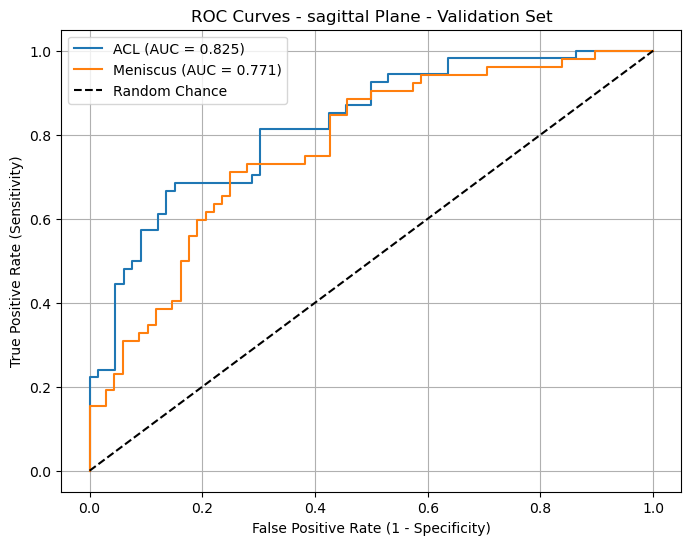

In [9]:
# --- Final Evaluation ---
print(f"\n--- Final Evaluation on Validation Set using Best Model ---")
print(f"Loading best model weights from: {MODEL_SAVE_PATH}")

if os.path.exists(MODEL_SAVE_PATH):
    # Load the model saved by ModelCheckpoint
    best_model = tf.keras.models.load_model(MODEL_SAVE_PATH)
    print("Best model loaded successfully.")

    # Evaluate using the aggregated evaluation function
    validation_results = evaluate_model_aggregated(best_model,
                                                   valid_data_dir,
                                                   PLANE,
                                                   valid_labels_acl,
                                                   valid_labels_meniscus,
                                                   valid_exam_ids,
                                                   IMG_SIZE)

    # Optional: Plot ROC Curves for the validation set
    if validation_results:
        print("\nPlotting ROC Curves for Validation Set...")
        plt.figure(figsize=(8, 6))

        # ACL ROC
        fpr_acl, tpr_acl, _ = roc_curve(validation_results['acl']['true'], validation_results['acl']['pred_prob'])
        plt.plot(fpr_acl, tpr_acl, label=f"ACL (AUC = {validation_results['acl']['auc']:.3f})")

        # Meniscus ROC
        fpr_men, tpr_men, _ = roc_curve(validation_results['meniscus']['true'], validation_results['meniscus']['pred_prob'])
        plt.plot(fpr_men, tpr_men, label=f"Meniscus (AUC = {validation_results['meniscus']['auc']:.3f})")

        plt.plot([0, 1], [0, 1], 'k--', label='Random Chance') # Diagonal line
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.title(f'ROC Curves - {PLANE} Plane - Validation Set')
        plt.legend()
        plt.grid(True)
        plt.show()

else:
    print(f"Error: Best model file not found at {MODEL_SAVE_PATH}. Evaluation skipped.")
    print("This might happen if training was interrupted or did not improve over initial weights.")